Connected to Python 3.11.4

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from binance.client import Client
from scipy import stats
from datetime import *
import datetime
from scipy.optimize import minimize

api_key = ''
api_secret = ''
client = Client(api_key, api_secret)
"""
crpto = {'BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'XRPUSDT', 'DAIUSDT', 
        'USDCUSDT', 'SOLUSDT', 'TRXUSDT', 'ADAUSDT', 'MATICUSDT', 
        'DOGEUSDT', 'LINKUSDT', 'WBTCUSDT', 'DOTUSDT', 'LTCUSDT', 
        'BCHUSDT', 'SHIBUSDT', 'AVAXUSDT', 'TUSDUSDT', 'XLMUSDT', 
        'XMRUSDT', 'ATOMUSDT', 'UNIUSDT', 'ETCUSDT', 'HBARUSDT', 
        'FILUSDT', 'ICPUSDT', 'APTUSDT', 'LDOUSDT', 'MKRUSDT', 
        'WBETHUSDT', 'VETUSDT', 'QNTUSDT', 'OPUSDT', 'NEARUSDT', 
        'AAVEUSDT', 'INJUSDT', 'ARBUSDT', 'GRTUSDT', 'RNDRUSDT', 
        'STXUSDT', 'RUNEUSDT', 'ALGOUSDT', 'IMXUSDT', 'EGLDUSDT', 
        'AXSUSDT', 'XTZUSDT', 'EOSUSDT', 'SANDUSDT', 'THETAUSDT'}
"""
crpto = {'BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'XRPUSDT', 'DAIUSDT', 
        'USDCUSDT', 'SOLUSDT', 'TRXUSDT', 'ADAUSDT', 'MATICUSDT'}

d = dict()
for name in crpto:
#   klines = client.get_historical_klines(name, Client.KLINE_INTERVAL_1HOUR, '1 Jan, 2015')
    klines = client.get_historical_klines(name, Client.KLINE_INTERVAL_1DAY, '1 Jan, 2015')

    df = pd.DataFrame(klines)
    df.columns = ['Open_time','open','high','low','close','volume','Close_time', 'Quote asset volume', 'number of trades', 'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore']
    df = df.drop_duplicates(subset=['Open_time'], keep=False)
    df = df.astype(float)

    df['Open_time'] = pd.to_datetime(df['Open_time'], unit='ms')
    df = df.drop(columns=['Close_time', 'Quote asset volume', 'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore'])
    df.set_index('Open_time', inplace=True)

    d[name] = df
    df.to_csv(name + '.csv', encoding='utf-8')

In [76]:
for name in d:
    d[name]['logPrice'] = np.log(d[name]['close'])

for df in d.values():
    df['return'] = (df['close'] - df['open']) / df['open']

In [77]:
import scipy.optimize as optim
from sympy.utilities.lambdify import lambdify
from sympy import symbols,pi,exp,log,summation,diff,simplify,solve,nsolve,factorial,gamma
import sys
# sys.setrecursionlimit(100)

beta: 1.249255 intercept -4.098820
R-squared: 0.763215


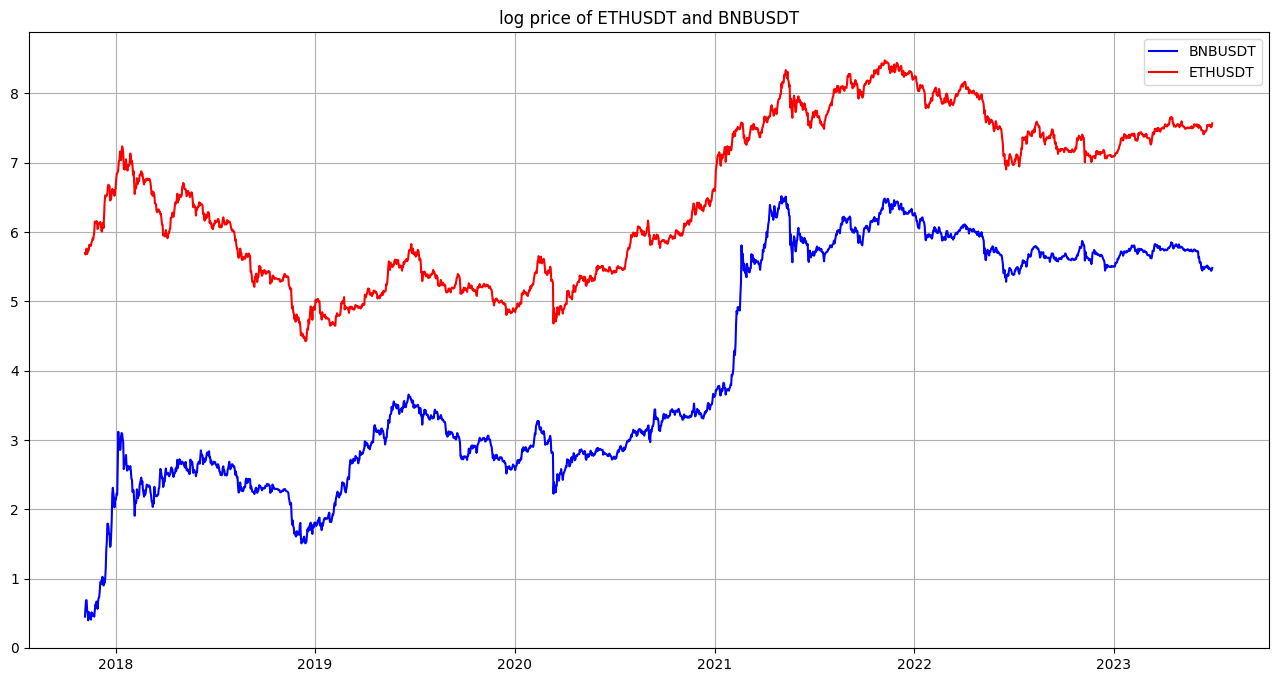

In [78]:
name_Q = 'ETHUSDT'
name_P = 'BNBUSDT'

start = max(d[name_P].index[0], d[name_Q].index[0])
end = datetime.datetime(2023, 6, 30, 23)  

logP = d[name_P]['logPrice'].loc[start : end]
logQ = d[name_Q]['logPrice'].loc[start : end]

slope, intercept, r_value, p_value, std_err = stats.linregress(logQ, logP)
print("beta: %f intercept %f" % (slope, intercept))
print("R-squared: %f" % r_value ** 2)

X = logP - slope * logQ
n = len(X)

plt.figure(figsize=(16, 8))
plt.plot(logP, label = name_P, color = 'blue')
plt.plot(logQ, label = name_Q, color = 'red')
plt.title(f"log price of {name_Q} and {name_P}")
plt.grid('True')
plt.legend()
plt.show()

mu = -4.098819782454875, theta = 0.004226311620622025, sigma = 0.48837096835619276, val = 5.3119512811262
a = 0.00201416015625, b = 0, c = 0.002
tilde_a1 = -4.088120661832489, tilde_a2 = -4.1095189030772605, tilde_b = -4.098819782454875, tilde_c = 0.010623902562252402
a = 0.0009765625, b = -0.0009765625, c = 0.002
tilde_a1 = -4.0936323300319, tilde_a2 = -4.10400723487785, tilde_b = -4.10400723487785, tilde_c = 0.010623902562252402


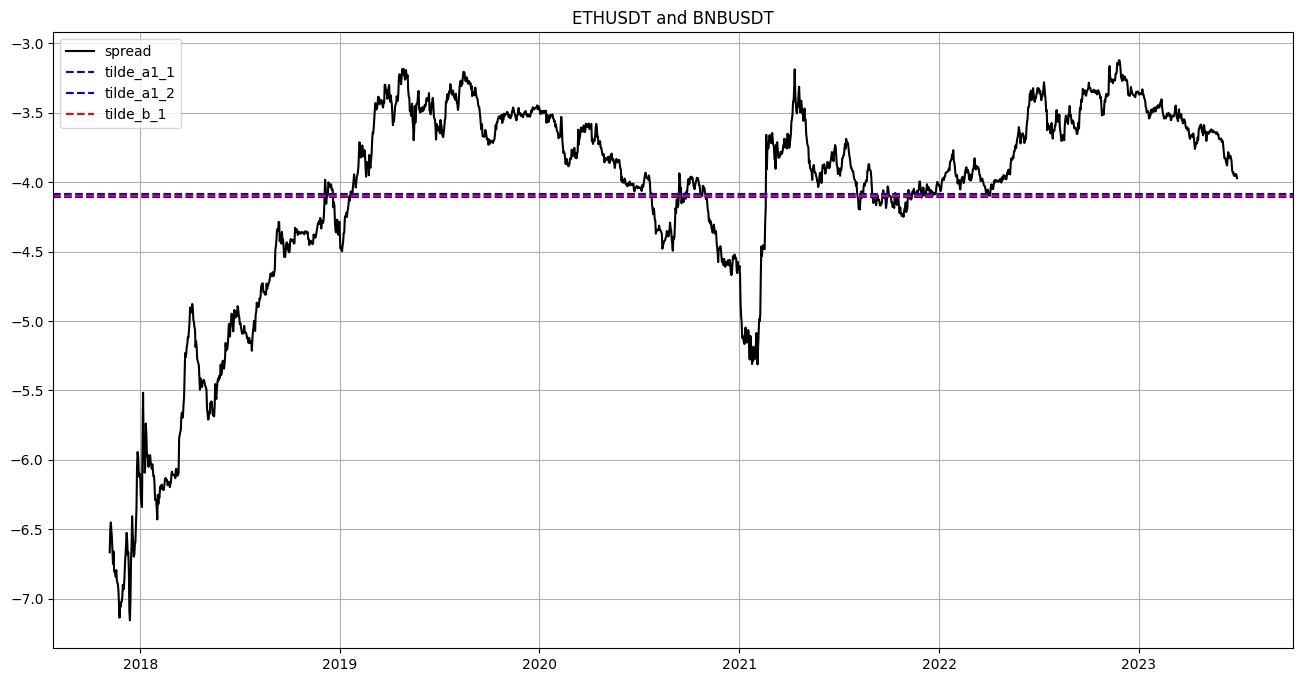

In [79]:
import scipy.optimize as optim
from sympy.utilities.lambdify import lambdify
from sympy import symbols,pi,exp,log,summation,diff,simplify,solve,nsolve,factorial,gamma, sqrt
import sys
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
sys.setrecursionlimit(1000)

"""
define parameters
"""
mu = X.mean()
theta = symbols('theta')
sigma = symbols('sigma')
n = X.shape[0]
dt = 1/n
inf = float('inf')

"""
OU process params estimate
"""
llf_1 = 0
for i in range(1, n-1): 
    llf_1 = llf_1 + log(1 - exp(-2 * theta * dt))

llf_2 = 0
for i in range(1, n-1):
    llf_2 = llf_2 + (X[i] - mu - (X[i-1] - mu) * exp(-theta * dt)) / (1 - exp(-2 * theta * dt))

llf = (-1 * n/2 - 0.5 * llf_1 - (theta/sigma**2) * llf_2)*(-1)

llf = lambdify((theta, sigma), llf)

def equation(x):
    theta = x[0]
    sigma = x[1]
    return abs(llf(theta, sigma))

init = np.array([0.001, 0.01])
sol = optim.minimize(equation, x0 = init, method = 'Nelder-Mead', options = {"disp": False}) 
theta = sol.x[0]
sigma = sol.x[1]
print(f'mu = {mu}, theta = {theta}, sigma = {sigma}, val = {sigma/((2*theta)**0.5)}')

"""
Case 1 boundary estimate
"""
a_1 = symbols('a_1')
b_1 = 0
c_1 = 0.002
max_eq_1 = 0

for j in range(0, 100):
    max_eq_1 += (a_1-c_1) * (sqrt(2)/2) * (sqrt(2)*a_1)**(2*j)/factorial(2*j) * factorial(j + 0.5)
max_eq_1_neg = -max_eq_1
max_eq_1_neg = lambdify(a_1, max_eq_1_neg)

def equation_1(x):
    a_1 = x[0]
    return abs(max_eq_1_neg(a_1))

init_1 = 10
sol_1 = optim.minimize(equation_1, x0 = init_1, method = 'Nelder-Mead')
a_1 = sol_1.x[0]
print(f'a = {a_1}, b = {b_1}, c = {c_1}')

## return a_1, b_1, c_1
tilde_a1_1 = a_1 * sigma / ((2 * theta)**0.5) + mu
tilde_a1_2 = -a_1 * sigma / ((2 * theta)**0.5) + mu
tilde_b_1 = b_1 * sigma / ((2 * theta)**0.5) + mu
tilde_c_1 = c_1 * sigma / ((2 * theta)**0.5)
print(f'tilde_a1 = {tilde_a1_1}, tilde_a2 = {tilde_a1_2}, tilde_b = {tilde_b_1}, tilde_c = {tilde_c_1}')
## return tilde_a1_1, tilde_a1_2, tilde_b_1, tilde_c_1

"""
Case 2 boundary estimate
"""
a_2 = symbols('a_2')
c_2 = 0.002
max_eq_2 = 0

for j in range(0, 100):
    max_eq_2 += (a_2 - 0.5*c_2) * (sqrt(2)/2) * (sqrt(2)*a_2)**(2*j)/factorial(2*j) * factorial(j + 0.5)
max_eq_2_neg = -max_eq_2
max_eq_2_neg = lambdify(a_2, max_eq_2_neg)

def equation_2(x):
    a_2 = x[0]
    return abs(max_eq_2_neg(a_2))

init_2 = 10
sol_2 = optim.minimize(equation_2, x0 = init_2, method = 'Nelder-Mead')
a_2 = sol_2.x[0]
b_2 = -a_2
print(f'a = {a_2}, b = {b_2}, c = {c_2}')

## return a_2, b_2, c_2
tilde_a2_1 = a_2 * sigma / ((2 * theta)**0.5) + mu
tilde_a2_2 = -a_2 * sigma / ((2 * theta)**0.5) + mu
tilde_b_2 = b_2 * sigma / ((2 * theta)**0.5) + mu
tilde_c_2 = c_2 * sigma / ((2 * theta)**0.5)
print(f'tilde_a1 = {tilde_a2_1}, tilde_a2 = {tilde_a2_2}, tilde_b = {tilde_b_2}, tilde_c = {tilde_c_2}')
## return tilde_a2_1, tilde_a2_2, tilde_b_2, tilde_c_2

## case_1(mu, theta, sigma)
## case_2(mu, theta, sigma)

plt.figure(figsize=(16, 8))
plt.plot(X, label = 'spread', color = 'black')
plt.axhline(y = tilde_a1_1, color = 'blue', linestyle = '--', label = 'tilde_a1_1')
plt.axhline(y = tilde_a1_2, color = 'blue', linestyle = '--', label = 'tilde_a1_2')
plt.axhline(y = tilde_b_1, color = 'red', linestyle = '--', label = 'tilde_b_1')
plt.title(f"{name_Q} and {name_P}")
plt.grid('True')
plt.legend()
plt.show()

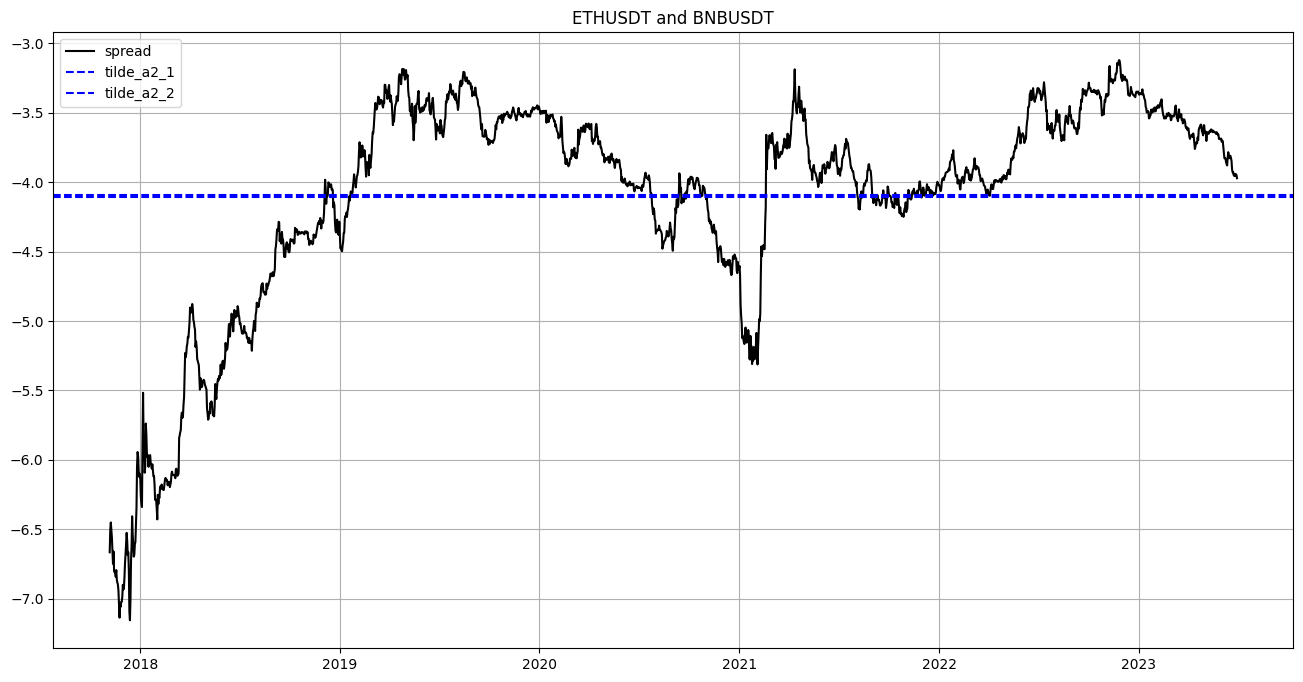

In [80]:
plt.figure(figsize=(16, 8))
plt.plot(X, label = 'spread', color = 'black')
plt.axhline(y = tilde_a2_1, color = 'blue', linestyle = '--', label = 'tilde_a2_1')
plt.axhline(y = tilde_a2_2, color = 'blue', linestyle = '--', label = 'tilde_a2_2')
plt.title(f"{name_Q} and {name_P}")
plt.grid('True')
plt.legend()
plt.show()

Enter Position
Long BNBUSDT: 1.571, Short ETHUSDT: 302.0, time: 2017-11-06 00:00:00
Clear Position at 2018-12-04 00:00:00 BNBUSDT 5.902 and ETHUSDT 208.82
trade completed
------------------------------------------------------------------------------
Enter Position
Short BNBUSDT: 6.0727, Long ETHUSDT: 221.29, time: 2018-12-05 00:00:00
Clear Position at 2018-12-07 00:00:00 BNBUSDT 4.516 and ETHUSDT 196.16
trade completed
------------------------------------------------------------------------------
Enter Position
Long BNBUSDT: 4.516, Short ETHUSDT: 196.16, time: 2018-12-07 00:00:00
Clear Position at 2018-12-08 00:00:00 BNBUSDT 4.6361 and ETHUSDT 208.17
trade completed
------------------------------------------------------------------------------
Enter Position
Short BNBUSDT: 4.8973, Long ETHUSDT: 247.73, time: 2018-12-11 00:00:00
Clear Position at 2018-12-20 00:00:00 BNBUSDT 5.6766 and ETHUSDT 232.94
trade completed
------------------------------------------------------------------------

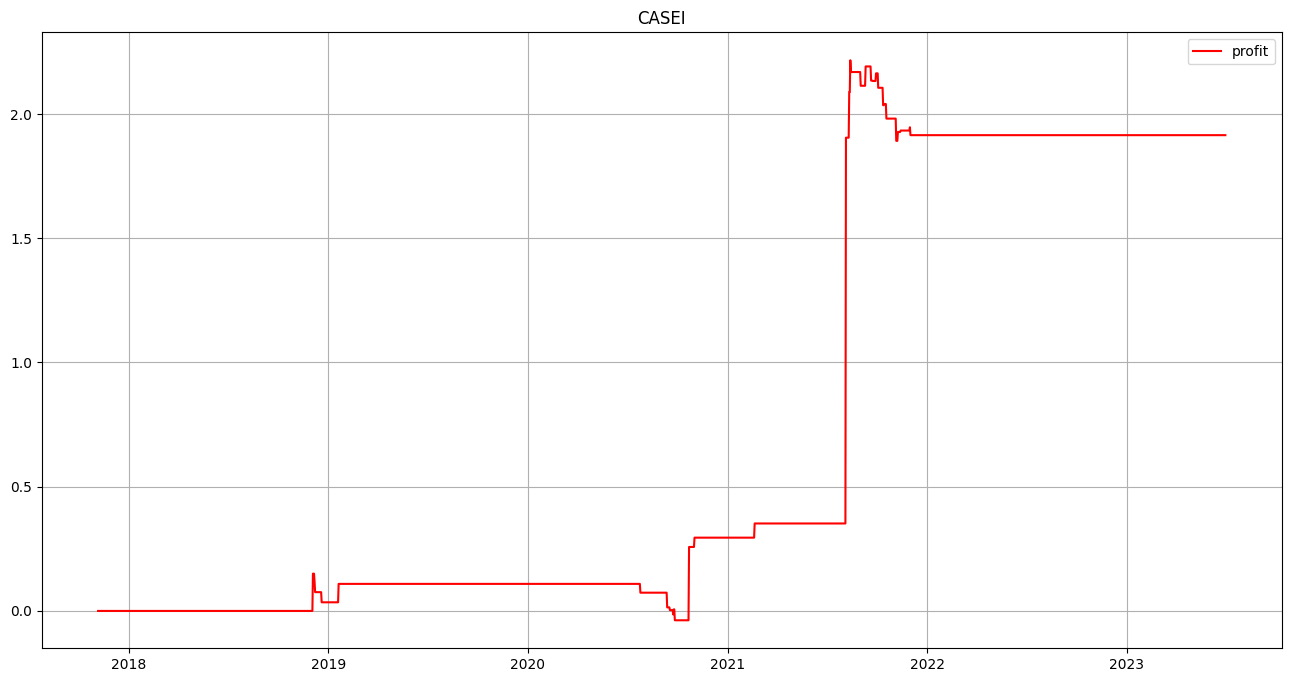

In [100]:
BS = None
fund = 1
tradeTimes = 0
enter = []
clear = []
profit_list = [0] * n
profit_P_list = [0] * n
profit_Q_list = [0] * n
profit_fee_list = [0] * n
profit_fee_list_realized = []
rets = []
c = 0.002

for i in range(len(X)):

    if i == len(X)-1:
        break

    ## 進場邏輯
    entryLong = X[i] >= tilde_a1_1 # short P, long beta Q
    exitLong = X[i] <= tilde_b_1
    entryShort = X[i] <= tilde_a1_2 # long P, short beta Q
    exitShort = X[i] >= tilde_b_1

    if BS == 'B':
        if exitLong:
            profit_P = ((d[name_P]['close'][t] - d[name_P]['close'][i]) / (1 + slope)) * (1 / (d[name_P]['close'][t] + d[name_Q]['close'][t]))
            profit_Q = ((slope * (d[name_Q]['close'][i + 1] - d[name_Q]['close'][t])) / (1 + slope)) * (1 / (d[name_P]['close'][t] + d[name_Q]['close'][t]))
            print("Clear Position at {} {} {} and {} {}".format(X.index[i], name_P, d[name_P]['close'][i], name_Q, d[name_Q]['close'][i]))
            print("trade completed")
            print("------------------------------------------------------------------------------")
            profit_P_list[i] += profit_P
            profit_Q_list[i] += profit_Q
            # Realized PnL
            profit = profit_Q + profit_P
            profit_fee_realized = profit_Q + profit_P - c * 2
            profit_list[i] += profit
            profit_fee_list[i] += profit_fee_realized
            profit_fee_list_realized.append(profit_fee_realized)
            tradeTimes += 1
            clear.append(i)
            BS = None
    
    if BS == 'S':
        if exitShort:
            profit_P = ((d[name_P]['close'][i] - d[name_P]['close'][t]) / (1 + slope)) * (1 / (d[name_P]['close'][t] + d[name_Q]['close'][t]))
            profit_Q = ((slope * (d[name_Q]['close'][t] - d[name_Q]['close'][i+1])) / (1 + slope)) * (1 / (d[name_P]['close'][t] + d[name_Q]['close'][t]))
            print("Clear Position at {} {} {} and {} {}".format(X.index[i], name_P, d[name_P]['close'][i], name_Q, d[name_Q]['close'][i]))
            print("trade completed")
            print("------------------------------------------------------------------------------")
            profit_P_list[i] += profit_P
            profit_Q_list += profit_Q
            # Realized PnL
            profit = profit_Q + profit_P
            profit_fee_realized = profit_Q + profit_P - c * 2
            profit_list[i] += profit
            profit_fee_list[i] += profit_fee_realized
            profit_fee_list_realized.append(profit_fee_realized)
            tradeTimes += 1
            clear.append(i)
            BS = None

    if BS == None:
        if entryLong:
            BS = 'B'
            t = i
            enter.append(i)
            print("Enter Position")
            print("Short {}: {}, Long {}: {}, time: {}".format(name_P, d[name_P]['close'][t], name_Q, d[name_Q]['close'][t], X.index[t]))

        elif entryShort:
            BS = 'S'
            t = i
            enter.append(i)
            print("Enter Position")
            print("Long {}: {}, Short {}: {}, time: {}".format(name_P, d[name_P]['close'][t], name_Q, d[name_Q]['close'][t], X.index[t]))

equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=X.index)
print(equity)
plt.figure(figsize=(16, 8))
plt.plot(equity['profitfee'], label = 'profit', color = 'red')
plt.title("CASEI")
plt.grid('True')
plt.legend()
plt.show()

Profit :  1.9146972906073088
Return :  1.9146972906073088
Max DrawDown :  0.16315315746575187
Caimar Ratio :  11.735582199867817
Trade Times :  32
Win Rate :  0.46875
Profit Factor :  3.548071786051082


Text(0.5, 1.0, 'CASE I')

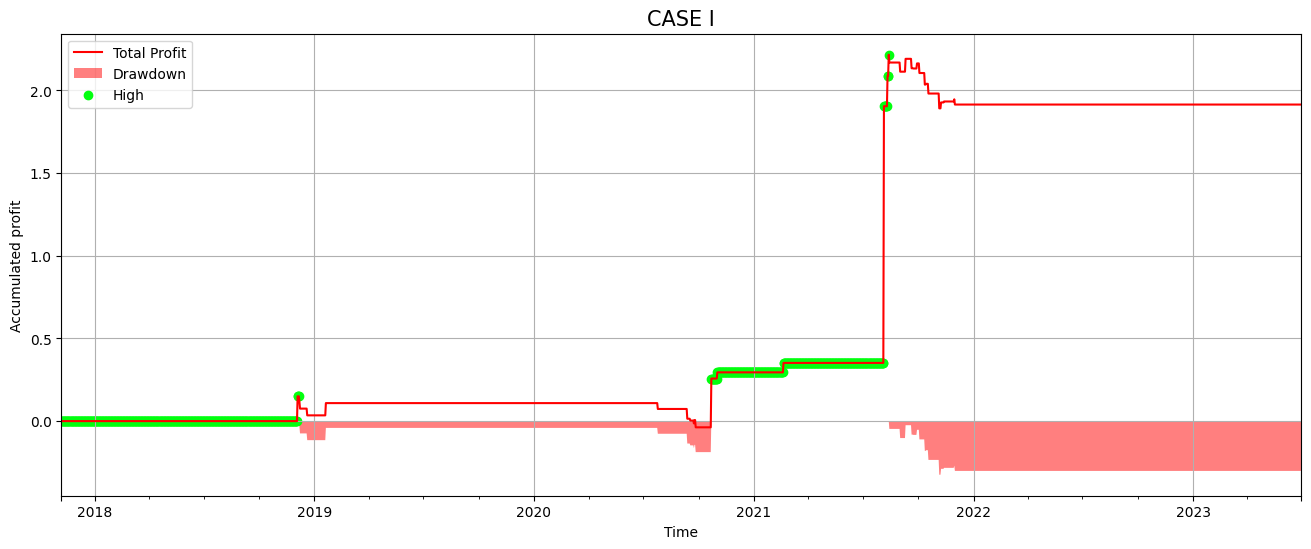

In [101]:
equity['equity'] = equity['profitfee'] + fund
equity['drawdown_percent'] = (equity['equity']/equity['equity'].cummax()) - 1
equity['drawdown'] = equity['equity'] - equity['equity'].cummax() #前n個元素的最大值
#print(profit_fee_list_realized)
profit = equity['profitfee'].iloc[-1]
ret = equity['equity'][-1]/equity['equity'][0] - 1
mdd = abs(equity['drawdown_percent'].min())
calmarRatio = ret / mdd
winRate = len([i for i in profit_fee_list_realized if i >= 0]) / len(profit_fee_list_realized)
profitFactor = sum([i for i in profit_fee_list_realized if i>0]) / abs(sum([i for i in profit_fee_list_realized if i<0]))

print('Profit : ',profit)
print('Return : ',ret)
print('Max DrawDown : ',mdd)
print('Caimar Ratio : ',calmarRatio)
print('Trade Times : ',tradeTimes)
print('Win Rate : ',winRate)
print('Profit Factor : ',profitFactor)

fig, ax = plt.subplots(figsize = (16, 6))
high_index = equity[equity['profitfee'].cummax() == equity['profitfee']].index
equity['profitfee'].plot(label = 'Total Profit', ax = ax, color = 'red', grid = True)
plt.fill_between(equity['drawdown'].index, equity['drawdown'], 0, facecolor = 'red', label = 'Drawdown', alpha = 0.5)
plt.scatter(high_index, equity['profitfee'].loc[high_index], color = '#02ff0f', label = 'High')

plt.legend()
plt.ylabel('Accumulated profit')
plt.xlabel('Time')
plt.title('CASE I', fontsize = 15)

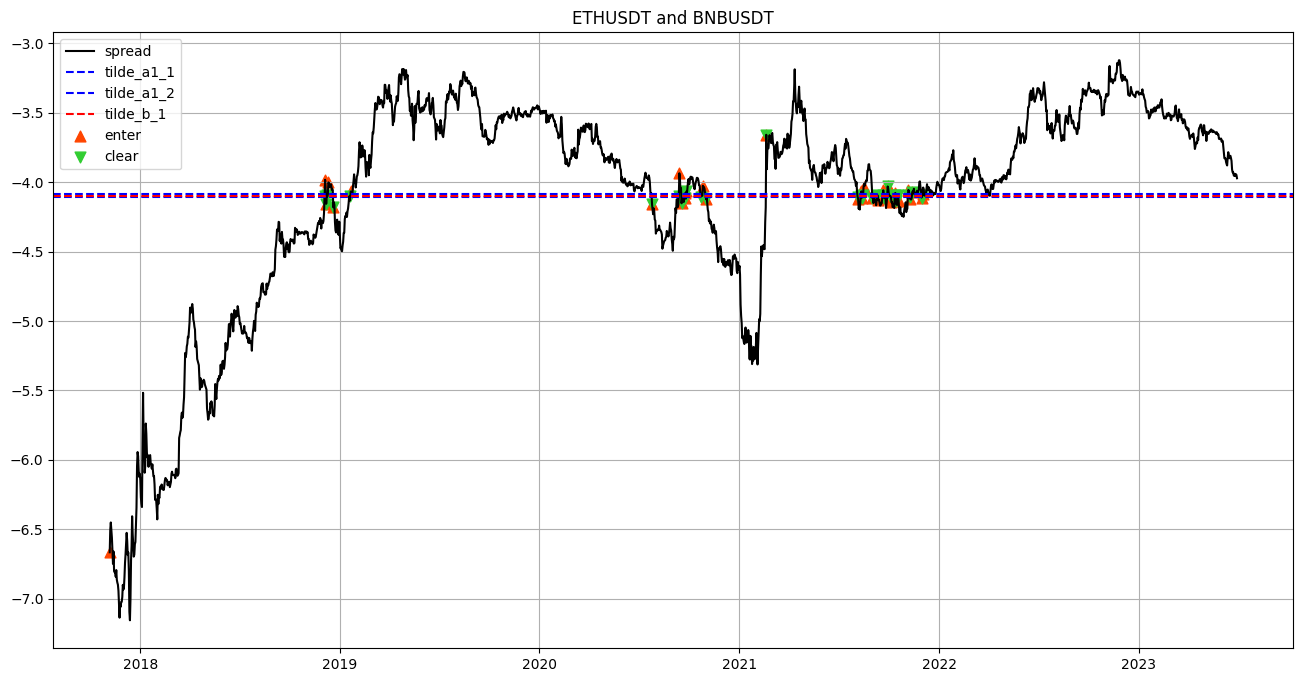

In [102]:
plt.figure(figsize=(16, 8))
plt.plot(X, label = 'spread', color = 'black')
plt.axhline(y = tilde_a1_1, color = 'blue', linestyle = '--', label = 'tilde_a1_1')
plt.axhline(y = tilde_a1_2, color = 'blue', linestyle = '--', label = 'tilde_a1_2')
plt.axhline(y = tilde_b_1, color = 'red', linestyle = '--', label = 'tilde_b_1')
plt.scatter(X.iloc[enter].index, X.iloc[enter],c = 'orangered', label = 'enter', marker='^', s=60)
plt.scatter(X.iloc[clear].index, X.iloc[clear],c = 'limegreen', label = 'clear', marker='v', s=60)
plt.title(f"{name_Q} and {name_P}")
plt.grid('True')
plt.legend()
plt.show()

Enter Position
Long BNBUSDT: 1.571, Short ETHUSDT: 302.0, time: 2017-11-06 00:00:00
Clear Position at 2018-12-05 00:00:00 BNBUSDT 6.0727 and ETHUSDT 221.29
trade completed
------------------------------------------------------------------------------
Enter Position
Short BNBUSDT: 6.0727, Long ETHUSDT: 221.29, time: 2018-12-05 00:00:00
Clear Position at 2018-12-07 00:00:00 BNBUSDT 4.516 and ETHUSDT 196.16
trade completed
------------------------------------------------------------------------------
Enter Position
Long BNBUSDT: 4.516, Short ETHUSDT: 196.16, time: 2018-12-07 00:00:00
Clear Position at 2018-12-08 00:00:00 BNBUSDT 4.6361 and ETHUSDT 208.17
trade completed
------------------------------------------------------------------------------
Enter Position
Short BNBUSDT: 4.6361, Long ETHUSDT: 208.17, time: 2018-12-08 00:00:00
Clear Position at 2018-12-20 00:00:00 BNBUSDT 5.6766 and ETHUSDT 232.94
trade completed
-----------------------------------------------------------------------

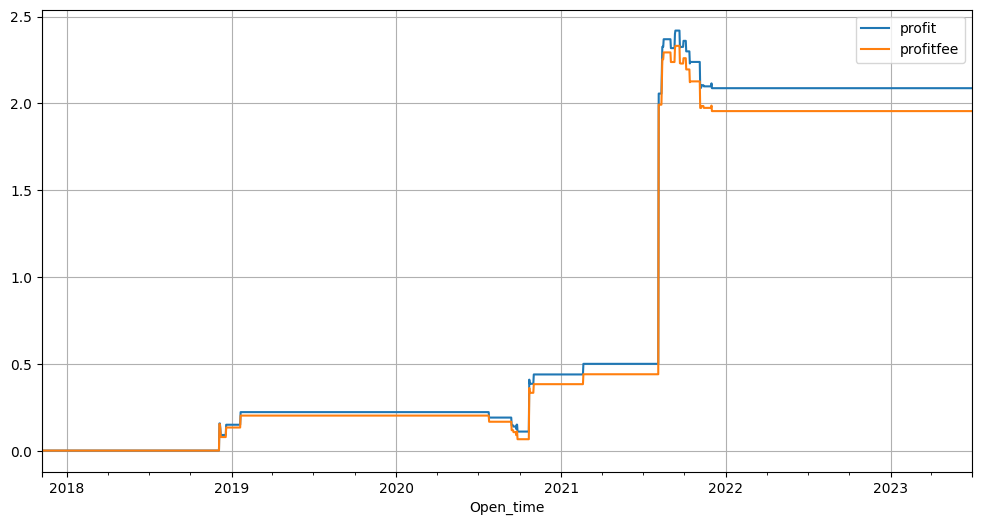

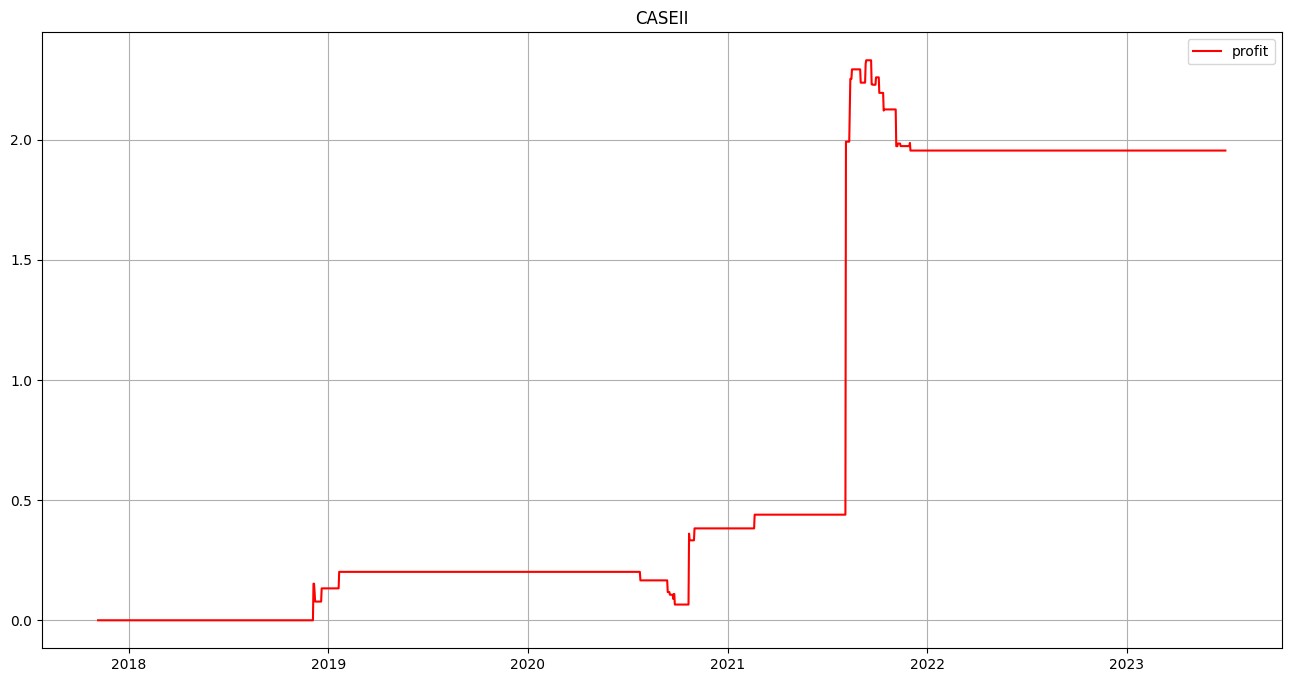

In [103]:
BS = None
fund = 1
tradeTimes = 0
enter = []
clear = []
profit_list = [0] * n
profit_P_list = [0] * n
profit_Q_list = [0] * n
profit_fee_list = [0] * n
profit_fee_list_realized = []
rets = []
c = 0.002

for i in range(len(X)):

    if i == len(X)-1:
        break

    ## 進場邏輯
    entryLong = X[i] >= tilde_a2_1 # short P, long beta Q
    exitLong = X[i] <= tilde_a2_2
    entryShort = X[i] <= tilde_a2_2 # long P, short beta Q
    exitShort = X[i] >= tilde_a2_1

    if BS == 'B':
        if exitLong:
            profit_P = ((d[name_P]['close'][t] - d[name_P]['close'][i]) / (1 + slope)) * (1 / (d[name_P]['close'][t] + d[name_Q]['close'][t]))
            profit_Q = ((slope * (d[name_Q]['close'][i + 1] - d[name_Q]['close'][t])) / (1 + slope)) * (1 / (d[name_P]['close'][t] + d[name_Q]['close'][t]))
            print("Clear Position at {} {} {} and {} {}".format(X.index[i], name_P, d[name_P]['close'][i], name_Q, d[name_Q]['close'][i]))
            print("trade completed")
            print("------------------------------------------------------------------------------")
            profit_P_list[i] += profit_P
            profit_Q_list[i] += profit_Q
            # Realized PnL
            profit = profit_Q + profit_P
            profit_fee_realized = profit_Q + profit_P - c * 2
            profit_list[i] += profit
            profit_fee_list[i] += profit_fee_realized
            profit_fee_list_realized.append(profit_fee_realized)
            tradeTimes += 1
            clear.append(i)
            BS = None
    
    if BS == 'S':
        if exitShort:
            profit_P = ((d[name_P]['close'][i] - d[name_P]['close'][t]) / (1 + slope)) * (1 / (d[name_P]['close'][t] + d[name_Q]['close'][t]))
            profit_Q = ((slope * (d[name_Q]['close'][t] - d[name_Q]['close'][i+1])) / (1 + slope)) * (1 / (d[name_P]['close'][t] + d[name_Q]['close'][t]))
            print("Clear Position at {} {} {} and {} {}".format(X.index[i], name_P, d[name_P]['close'][i], name_Q, d[name_Q]['close'][i]))
            print("trade completed")
            print("------------------------------------------------------------------------------")
            profit_P_list[i] += profit_P
            profit_Q_list += profit_Q
            # Realized PnL
            profit = profit_Q + profit_P
            profit_fee_realized = profit_Q + profit_P - c * 2
            profit_list[i] += profit
            profit_fee_list[i] += profit_fee_realized
            profit_fee_list_realized.append(profit_fee_realized)
            tradeTimes += 1
            clear.append(i)
            BS = None

    if BS == None:
        if entryLong:
            BS = 'B'
            t = i
            enter.append(i)
            print("Enter Position")
            print("Short {}: {}, Long {}: {}, time: {}".format(name_P, d[name_P]['close'][t], name_Q, d[name_Q]['close'][t], X.index[t]))

        elif entryShort:
            BS = 'S'
            t = i
            enter.append(i)
            print("Enter Position")
            print("Long {}: {}, Short {}: {}, time: {}".format(name_P, d[name_P]['close'][t], name_Q, d[name_Q]['close'][t], X.index[t]))

equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=X.index)
print(equity)
equity.plot(grid=True, figsize=(12,6))
plt.figure(figsize=(16, 8))
plt.plot(equity['profitfee'], label = 'profit', color = 'red')
plt.title("CASEII")
plt.grid('True')
plt.legend()
plt.show()

Profit :  1.9553291408470876
Return :  1.9553291408470876
Max DrawDown :  0.1132555483698443
Caimar Ratio :  17.264753638928283
Trade Times :  33
Win Rate :  0.5151515151515151
Profit Factor :  3.6091559210753665


Text(0.5, 1.0, 'CASE II')

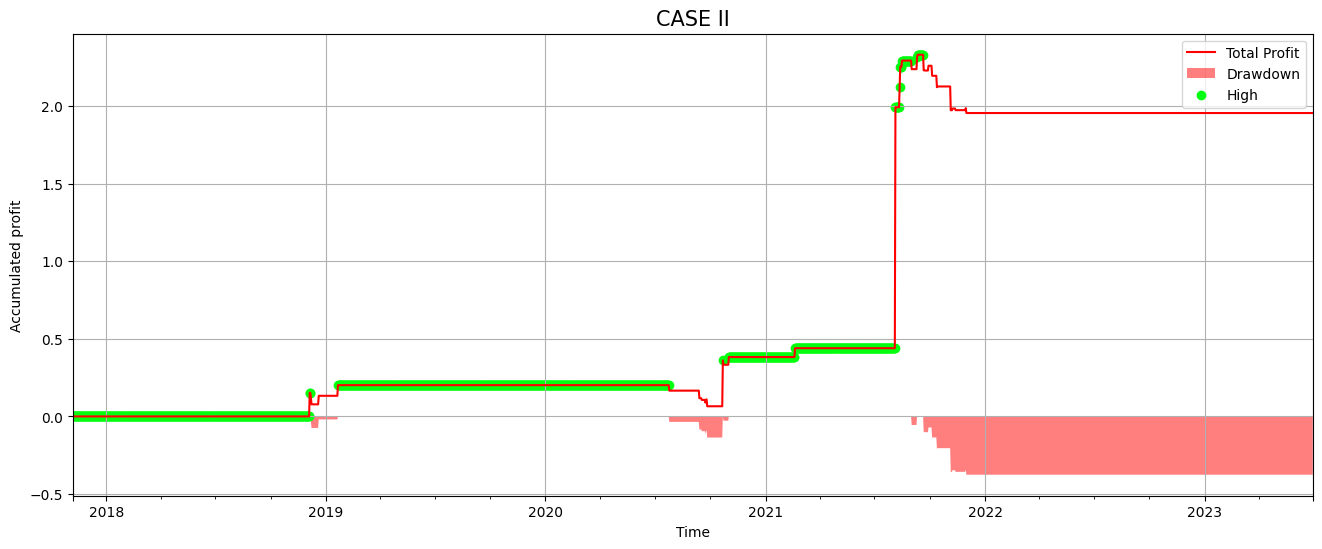

In [104]:
equity['equity'] = equity['profitfee'] + fund
equity['drawdown_percent'] = (equity['equity']/equity['equity'].cummax()) - 1
equity['drawdown'] = equity['equity'] - equity['equity'].cummax() #前n個元素的最大值
#print(profit_fee_list_realized)
profit = equity['profitfee'].iloc[-1]
ret = equity['equity'][-1]/equity['equity'][0] - 1
mdd = abs(equity['drawdown_percent'].min())
calmarRatio = ret / mdd
winRate = len([i for i in profit_fee_list_realized if i > 0]) / len(profit_fee_list_realized)
profitFactor = sum([i for i in profit_fee_list_realized if i>0]) / abs(sum([i for i in profit_fee_list_realized if i<0]))

print('Profit : ',profit)
print('Return : ',ret)
print('Max DrawDown : ',mdd)
print('Caimar Ratio : ',calmarRatio)
print('Trade Times : ',tradeTimes)
print('Win Rate : ',winRate)
print('Profit Factor : ',profitFactor)

fig, ax = plt.subplots(figsize = (16, 6))
high_index = equity[equity['profitfee'].cummax() == equity['profitfee']].index
equity['profitfee'].plot(label = 'Total Profit', ax = ax, color = 'red', grid = True)
plt.fill_between(equity['drawdown'].index, equity['drawdown'], 0, facecolor = 'red', label = 'Drawdown', alpha = 0.5)
plt.scatter(high_index, equity['profitfee'].loc[high_index], color = '#02ff0f', label = 'High')

plt.legend()
plt.ylabel('Accumulated profit')
plt.xlabel('Time')
plt.title('CASE II', fontsize = 15)

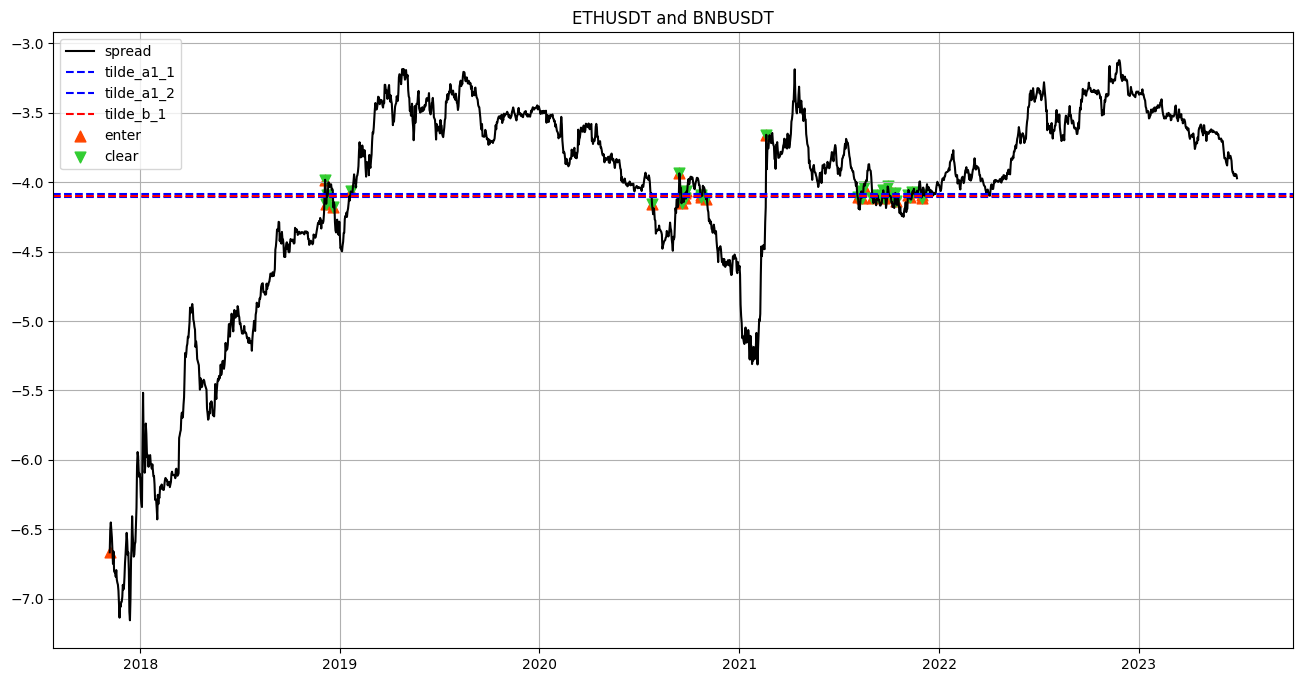

In [105]:
plt.figure(figsize=(16, 8))
plt.plot(X, label = 'spread', color = 'black')
plt.axhline(y = tilde_a1_1, color = 'blue', linestyle = '--', label = 'tilde_a1_1')
plt.axhline(y = tilde_a1_2, color = 'blue', linestyle = '--', label = 'tilde_a1_2')
plt.axhline(y = tilde_b_1, color = 'red', linestyle = '--', label = 'tilde_b_1')
plt.scatter(X.iloc[enter].index, X.iloc[enter],c = 'orangered', label = 'enter', marker='^', s=60)
plt.scatter(X.iloc[clear].index, X.iloc[clear],c = 'limegreen', label = 'clear', marker='v', s=60)
plt.title(f"{name_Q} and {name_P}")
plt.grid('True')
plt.legend()
plt.show()